# Notebook Count/TFIDF - SVD - ML (Git)

**Disclaimer :** Si vous avez lu le notebook **Notebook Count/TFIDF - Chi2 - ML**, vous pouvez directement aller à la partie **Sélection des features avec la reduction de dimension (SVD/LSA)**

## Imports et chargemement des données

In [2]:
## for data
import json
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for processing
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection

# machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD

import sklearn.metrics as metrics
import seaborn as sns

data = pd.read_json('../Data/data.json')
category = pd.read_csv('../Data/categories_string.csv')
label = pd.read_csv('../Data/label.csv')

data.head()

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
10,8,Her teachings get straight to the heart of Ta...,F
100,80,"She founded Couples Therapy Inc, where she pr...",F
1000,780,He is the head of the Christian Doppler Labor...,M


## Création d'une nouvelle colonne dans le dataset correspondant à l'id de la catégorie de poste

On visualise les données dans les fichiers `data.json` et `categories_string.csv`.

In [3]:
data.head(10)

,Id,description,gender
0,0,She is also a Ronald D. Asmus Policy Entrepre...,F
1,1,He is a member of the AICPA and WICPA. Brent ...,M
10,8,Her teachings get straight to the heart of Ta...,F
100,80,"She founded Couples Therapy Inc, where she pr...",F
1000,780,He is the head of the Christian Doppler Labor...,M
10000,8015,She has worked in the field of disaster manag...,F
100000,80026,"She is a columnist for Russian Forbes, a free...",F
100003,80027,His patients gave him an average rating of 2....,M
100004,80028,Dr. Grunewald's areas of expertise consist of...,M
100005,80029,These areas are among Dr. Ennis's clinical in...,M


Les deux jeux de données sont liés par la colonne `Id`.  

On peut donc réaliser un merge des deux à partir des valeurs de cette colonne.

In [4]:
data = pd.merge(data, label, how="right", on="Id")

## Récupération d'une partie des données du dataset

Pour des raisons de ressources disponibles sur les machines (local ou AWS), on récupère une petite partie des données (ici, 10%).

In [5]:
data, data_other_part, y_studied_part, y_other_part = train_test_split(data, data["Category"], train_size=0.2, random_state=211101)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


On vérifie la distribution des données à l'aide du graphique suivant:

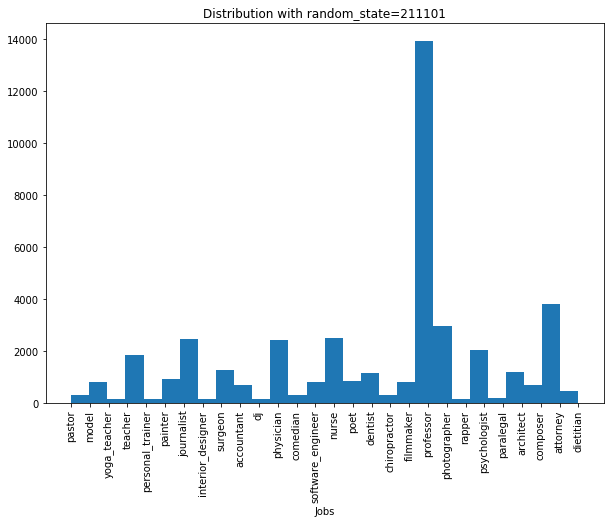

In [6]:
plt.figure(figsize=(10, 7))
plt.hist(data['Category'], 28)
plt.title("Distribution with random_state=211101")
plt.xlabel("Jobs")
plt.xticks(ticks = range(28), labels = category['0'], rotation = 'vertical')
plt.show()

On s'aperçoit que toutes les classes sont bien représentées.

## Préprocessing des extraits de CV

On crée une méthode permettant le préprocessing des extraits de CV. 

In [7]:
'''
Preprocess a CV extract
:parameter
    :param text: string - CV extract
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
    :param number: bool - whether number removal is to be applied
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned CV extract
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=None):
    ## clean --> convert to lowercase and remove punctuations and characters and then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    ## remove number in the text
    if number == True:
        text = re.sub('[0-9]+', '', text)
            
    ## convert from string to list
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.SnowballStemmer("english")
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

On récupère la liste de stopwords du module `nltk`.

In [8]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


On applique la fonction de préprocessing à la liste des extraits de CV. Le retour de la fonction est stocké dans une nouvelle colonne : `description_clean`.

In [9]:
nltk.download('wordnet')
data_clean = data
data_clean["description_clean"] = data_clean["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, number=True, lst_stopwords=lst_stopwords))
data_clean.head()

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Id,description,gender,Category,description_clean
51790,126621,"In addition, he also has a private practice t...",M,22,addition also private practice specializes ser...
65796,139223,"Without hesitation, Kat captures intricate mo...",F,20,without hesitation kat capture intricate momen...
44730,120248,"As a specialist in Yogācāra Buddhism, he has ...",M,19,specialist yogācāra buddhism done extensive re...
149460,214554,"He graduated at the University of Amsterdam, ...",M,19,graduated university amsterdam earned phd maas...
214410,77525,He has lived in Stockholm since 2008. Almadho...,M,15,lived stockholm since almadhoun published four...


## Première Vectorisation avec Count et TF-IDF
### Vectorizer Count
On applique le vectorizer `Count`. Il est basé sur la fréquence des mots.  

Cependant, cette méthode est peu utilisée, car un mot peut être très fréquent mais peu prédictif.

In [11]:
## Count (classic BoW)
vectorizerCount = feature_extraction.text.CountVectorizer(ngram_range=(1,1))

Application du modèle de vectorisation `Count` et affichage du nombre de mots dans le vocabulaire.

In [12]:
vectorizerCount.fit(data_clean["description_clean"])
data_count = vectorizerCount.transform(data_clean["description_clean"])
dic_vocabulary_Count = vectorizerCount.vocabulary_
len(dic_vocabulary_Count)

89769

 ### Vectorizer TF-IDF

La méthode `TF-IDF` semble plus adéquate pour notre application et permet de pallier au problème précédent.

In [13]:
## Tf-Idf (advanced variant of BoW)
vectorizerTfidf = feature_extraction.text.TfidfVectorizer(ngram_range=(1,1))

Application du modèle de vectorisation `TF-IDF` et affichage du nombre de mots dans le vocabulaire.

In [14]:
vectorizerTfidf.fit(data_clean["description_clean"])
data_Tfidf = vectorizerTfidf.transform(data_clean["description_clean"])
dic_vocabulary_Tfidf = vectorizerTfidf.vocabulary_
len(dic_vocabulary_Tfidf)

89769

## Sélection des features avec la reduction de dimension (SVD/LSA)

Puisque que la vectorization de nos documents nous renvoie des matrices creuses (matrice avec des valeurs "éparpillées"), il est plus judicieux d'utiliser la **réduction de dimension SVD** (ou LSA) avec l'algorithme `TruncatedSVD`. Cette réduction de la dimension linéaire est réalisée à partir d'une décomposition des valeurs singulières tronquées (SVD en anglais). Cette reduction est similaire à la PCA mais contrairement à celle-ci, l'estimateur ne centre pas les données avant de calculer la décomposition en valeur singulière. Cela signifie qu'il peut travailler efficacement avec des matrices creuses.

De plus, d'après la documentation
> In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

Documentation : [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

### Application du SVD pour le vectorizer Count

Nous utilisons les parametres par défaut, recommandés par la documentation

In [15]:
y = data_clean["Category"]
X_features_count = vectorizerCount.get_feature_names()

# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=0)
X_features_count = svd.fit_transform(data_count)

print('Taille du vocabulaire :', len(X_features_count))

Taille du vocabulaire : 43439


Regardons le pourcentage de la variance expliquée. La variance expliquée par la variable X est égale à la variance inter divisée par la variance globale de Y. La variance expliquée est une mesure du lien entre le facteur X et la mesure numérique Y, pour **évaluer comment Y dépend du fait d'appartenir à une sous-population ou à une autre** :

- Si la variance expliquée est égale ou se rapproche de 1, la variance intra vaut 0 ce qui entraîne que toutes les variances conditionnelles sont nulles par conséquent, les individus de chaque sous-population ont tous la même mesure Y.
- Si la variance expliquée est égale ou se rapproche de 0, la variance inter est nulle ce qui revient à dire que les moyennes conditionnelles de Y sont identiques : Y donne globalement les mêmes mesures sur toutes les sous-populations (attention X et Y sont pas indépendantes)

In [14]:
print(f"Pourcentage variance expliquée: {np.sum(svd.explained_variance_ratio_):.2f}")

Pourcentage variance expliquée: 0.32


Notre nouvelle représentation n'exprime qu'un faible pourcentage de la variance expliquée. Le choix du nombre de composantes qui couvrent le nouvel espace est généralement une question de quantité de variance expliquée souhaitée (et qui varie d'une application à l'autre). Pour la production, il serait interessant d'obtenir un **pourcentage de la variance expliquée plus important**.

Nous pouvons visualiser quelques features (même si il n'en ressort pas grand chose de pertinent)

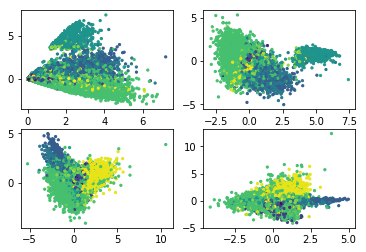

In [15]:
plt.subplot(221)
plt.scatter(X_features_count[:,0], X_features_count[:,1], c=y, s=5) 

plt.subplot(222)
plt.scatter(X_features_count[:,1], X_features_count[:,2], c=y, s=5) 

plt.subplot(223)
plt.scatter(X_features_count[:,3], X_features_count[:,4], c=y, s=5) 

plt.subplot(224)
plt.scatter(X_features_count[:,4], X_features_count[:,5], c=y, s=5) 
plt.show()

### Application du SVD pour le vectorizer TF-IDF

Réalisons la même application que précédement avec le vectorizer TF-IDF

In [16]:
y = data_clean["Category"]
X_features_Tfidf = vectorizerTfidf.get_feature_names()

# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_features_Tfidf = svd.fit_transform(data_Tfidf)

print('Taille du vocabulaire :', len(X_features_count))
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Taille du vocabulaire : 43439
Total variance explained: 0.14


Nous pouvons de même visualiser quelques features :

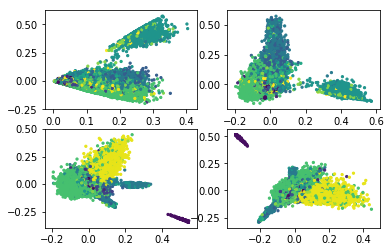

In [17]:
plt.subplot(221)
plt.scatter(X_features_Tfidf[:,0], X_features_Tfidf[:,1], c=y, s=5) 

plt.subplot(222)
plt.scatter(X_features_Tfidf[:,1], X_features_Tfidf[:,2], c=y, s=5) 

plt.subplot(223)
plt.scatter(X_features_Tfidf[:,3], X_features_Tfidf[:,4], c=y, s=5) 

plt.subplot(224)
plt.scatter(X_features_Tfidf[:,4], X_features_Tfidf[:,5], c=y, s=5) 
plt.show()

## Séparation du dataset en train et test

### Vectorizer Count

In [17]:
X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(X_features_count, y, test_size=0.2, random_state=211101)

### Vectorizer TF-IDF

In [18]:
X_Tfidf_train, X_Tfidf_test, y_Tfidf_train, y_Tfidf_test = train_test_split(X_features_Tfidf, y, test_size=0.2, random_state=211101)

## Entrainement des modèles de machine learning

Pour l'ensemble des modèles choisis, on réalise une pipeline permettant de tester et d'évaluer les modèles en fonction d'une combinaison d'hyperparamètres.  

Les deux méthodes suivantes permettent d'afficher les résultats de façon générale pour chaque modèle.

### Création d'une fonction pour étudier les résultats du modèle entrainé

In [19]:
'''
Affichage des résultats du modèle entrainé
:parameter
    :param model: Le modèle entrainé
    :param X_train: Le dataset d'entrée train
    :param y_train: Le dataset de sortie train
    :param X_test: Le dataset d'entrée test
    :param y_test: Le dataset de sortie train
'''
def display_stats_model_trained(model, X_train, y_train, X_test, y_test, display_graphics):

    ## Accuracy train and test, Precision, Recall
    #auc = metrics.roc_auc_score(y_test, predicted_prob)
    print("Accuracy:")
    print("\rTrain: ", model.score(X_train, y_train))
    print("\rTest: ", model.score(X_test, y_test))
    #print("Area under the curve (Auc): ", auc)
    print("")
    
    # Get predictions
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    if display_graphics == True:
        # Get dataset test categories
        classes = np.unique(y_test)
        y_test_array = pd.get_dummies(y_test, drop_first=False).values
        print("Detail:")
        print(metrics.classification_report(y_test, predicted))

        ## Plot confusion matrix
        cm = metrics.confusion_matrix(y_test, predicted)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
        ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
        plt.yticks(rotation=0)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

        ## Plot roc
        for i in range(len(classes)):
            fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
            ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
        ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                  xlabel='False Positive Rate', 
                  ylabel="True Positive Rate (Recall)", 
                  title="Receiver operating characteristic")
        ax[0].legend(loc="lower right")
        ax[0].grid(True)

        ## Plot precision-recall curve
        for i in range(len(classes)):
            precision, recall, thresholds = metrics.precision_recall_curve(
                         y_test_array[:,i], predicted_prob[:,i])
            ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i],  metrics.auc(recall, precision)))
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
        ax[1].legend(loc="best")
        ax[1].grid(True)
        plt.show()

Définitions utilisées pour comprendre la précision et le rappel :  

**Precision** : What proportion of positive identifications was actually correct?  
**Recall**: What proportion of actual positives was identified correctly?

### Création d'une fonction pour obtenir et afficher les résultats de la pipeline

In [20]:
def train_and_display_pipeline_results(model_grid, X_train, y_train, X_test, y_test):
    print('Train Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_train, y_train))
    print('Test Accuracy Best Estimator : ', model_grid.best_estimator_.score(X_test, y_test))
    print('Best Accuracy Through Grid Search : ', model_grid.best_score_)
    print('Best Parameters : ',model_grid.best_params_)
    

### Entrainement du modèle avec la famille d'algortihmes Naive Bayes

Il n'est pas possible d'appliquer une classification Naive Bayes après une reduction de dimension SVD, semblable  à la PCA. En effet, le classifieur NB a besoin de features avec **valeurs discrètes et positive** (la reduction de dimension de type PCA ne respecte pas cette propriété).

### Entrainement du modèle avec le classifier Random Forest

##### Avec le vectorizer Count

In [22]:
randomForest_count= RandomForestClassifier()

params = {
        'n_estimators': [100, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [100, 500]
         }

randomForest_count_Grid = GridSearchCV(randomForest_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
randomForest_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(randomForest_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.4s
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.6421500920810314
Best Accuracy Through Grid Search :  0.6411901815775085
Best Parameters :  {'max_depth': 500, 'max_features': 'auto', 'n_estimators': 500}


##### Avec le vectorizer TF-IDF

In [23]:
randomForest_Tdidf= RandomForestClassifier()

params = {
        'n_estimators': [100, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [100, 500]
         }

randomForest_Tfidf_Grid = GridSearchCV(randomForest_Tdidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
randomForest_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

train_and_display_pipeline_results(randomForest_Tfidf_Grid, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   59.4s
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by

Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.7062615101289135
Best Accuracy Through Grid Search :  0.7042099507927829
Best Parameters :  {'max_depth': 100, 'max_features': 'auto', 'n_estimators': 500}


On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy:
Train:  0.9931225000719404
Test:  0.6519337016574586

Detail:
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        55
           1       0.33      0.45      0.38       148
           2       0.65      0.46      0.54        28
           3       0.39      0.41      0.40       360
           4       0.19      0.07      0.10        42
           5       0.59      0.66      0.62       188
           6       0.44      0.55      0.49       487
           7       0.56      0.21      0.31        47
           8       0.55      0.54      0.54       240
           9       0.53      0.42      0.47       119
          10       0.12      0.11      0.12        27
          11       0.61      0.61      0.61       510
          12       0.54      0.33      0.41        63
          13       0.45      0.36      0.40       151
          14       0.77      0.70      0.73       486
          15       0.64      0.51      0.57       173
         

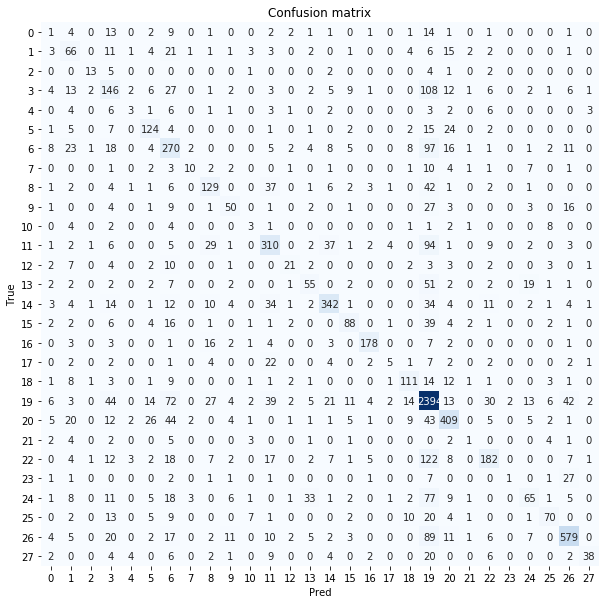

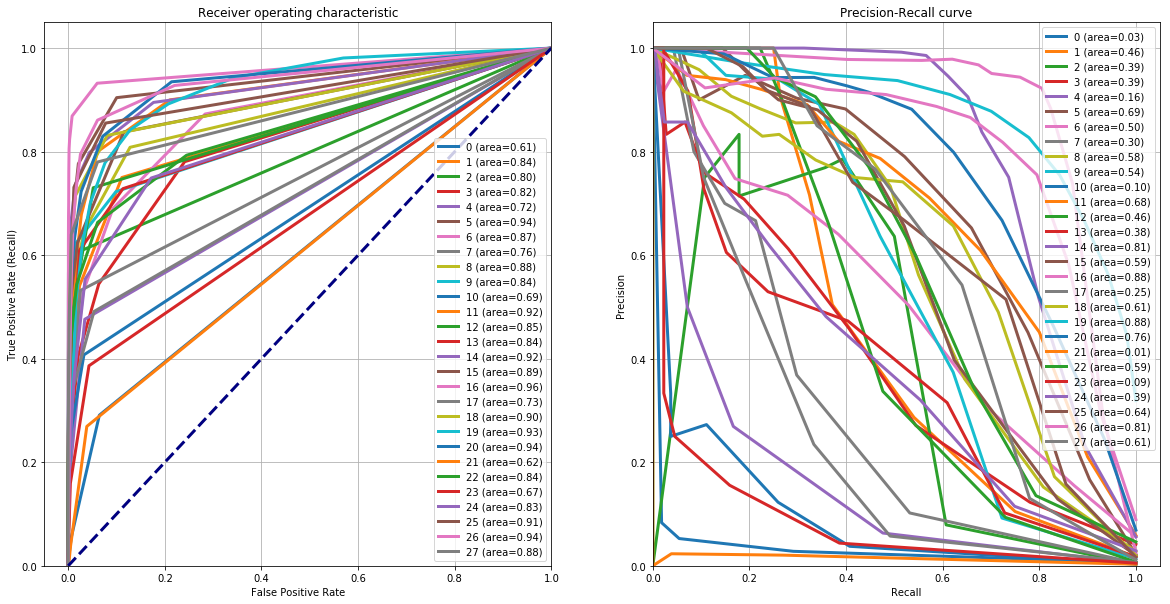

In [24]:
radom_forest_Tfidf = RandomForestClassifier(max_depth=100, random_state=0)
radom_forest_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(radom_forest_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

Les RandomForest ne fournissent pas de bons résultats de test (environ 65%). De plus, nous remarquons la présence d'un overfitting de part l'écart entre les données test et train.

### Entrainement du modèle avec le classifier KNN

##### Avec le vectorizer Count

In [25]:
kNeighbors_count= KNeighborsClassifier()

params = {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance']
         }

kNeighbors_count_Grid = GridSearchCV(kNeighbors_count, param_grid=params, n_jobs=-1, cv=5, verbose=5)
kNeighbors_count_Grid.fit(X_count_train, y_count_train)

train_and_display_pipeline_results(kNeighbors_count_Grid, X_count_train, y_count_train, X_count_test, y_count_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 63.0min remaining: 22.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 80.2min finished


Train Accuracy Best Estimator :  1.0
Test Accuracy Best Estimator :  0.5842541436464088
Best Accuracy Through Grid Search :  0.5873212281660959
Best Parameters :  {'n_neighbors': 5, 'weights': 'distance'}


##### Avec le vectorizer TF-IDF

In [19]:
kNeighbors_Tfidf= KNeighborsClassifier()

params = {
        'n_neighbors': [3, 4, 5],
        'weights': ['uniform', 'distance']
         }

kNeighbors_Tfidf_Grid = GridSearchCV(kNeighbors_Tfidf, param_grid=params, n_jobs=-1, cv=5, verbose=5)
kNeighbors_Tfidf_Grid.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(radom_forest_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed: 26.2min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 34.3min finished


NameError: name 'display_stats_model_trained' is not defined

Les meilleurs résultats, comme avec le Chi2, est pour `k=5`.

On affiche les métriques et graphiques pour ce vectorizer et avec les meilleurs hyperparamètres :

In [ ]:
KNN_Tfidf = KNeighborsClassifier(n_neighbors=5, weights='distance')
KNN_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(KNN_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

Ces meilleurs que ceux du RandomForest puisqu'ils ne présentent moins d'overfitting. Essayons d'améliorer la précision en utilisant des Neural Networks.

### Entrainement du modèle avec le classifier Neural Network

Pour des raisons de ressources matérielles à notre disposition, nous n'avons pas pu mettre en place une pipeline pour ce type de classifier. En effet, le nombre d'hyperparamètres étant important, la pipeline prenait un temps trop conséquent. L'étude se fera donc en pas à pas sur ce modèle.

##### Avec le vectorizer Count

Accuracy:
Train:  0.7953440188771547
Test:  0.7052255985267035

Detail:
              precision    recall  f1-score   support

           0       0.16      0.07      0.10        55
           1       0.57      0.53      0.55       148
           2       0.53      0.36      0.43        28
           3       0.51      0.47      0.49       360
           4       0.58      0.45      0.51        42
           5       0.65      0.65      0.65       188
           6       0.54      0.65      0.59       487
           7       0.50      0.28      0.36        47
           8       0.67      0.59      0.63       240
           9       0.62      0.59      0.60       119
          10       0.31      0.30      0.30        27
          11       0.65      0.66      0.66       510
          12       0.60      0.49      0.54        63
          13       0.50      0.58      0.54       151
          14       0.82      0.76      0.79       486
          15       0.60      0.62      0.61       173
         

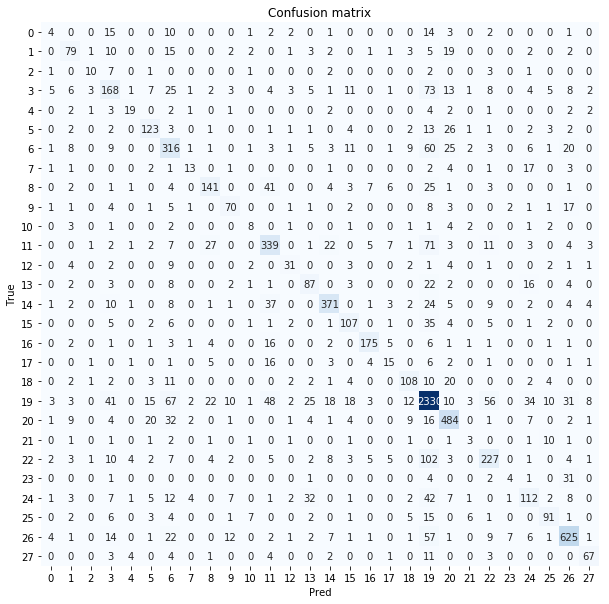

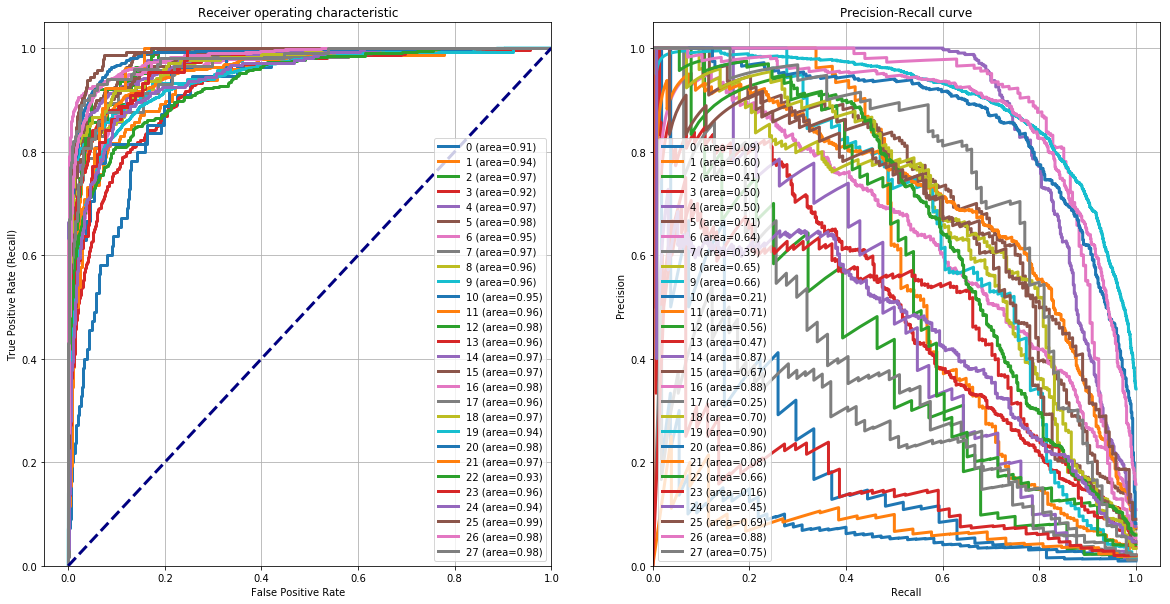

In [21]:
nn_count = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=1, activation="relu", max_iter=1000, random_state=0)
nn_count.fit(X_count_train, y_count_train)

display_stats_model_trained(nn_count, X_count_train, y_count_train, X_count_test, y_count_test, True)

##### Avec le vectorizer TF-IDF

On reprend les mêmes hyperparamètres pour l'entrainement du modèle basé sur le vectorizer `TF-IDF`.

Accuracy:
Train:  0.7793157031452332
Test:  0.7526473296500921

Detail:
              precision    recall  f1-score   support

           0       0.38      0.15      0.21        55
           1       0.62      0.64      0.63       148
           2       0.68      0.54      0.60        28
           3       0.54      0.48      0.51       360
           4       0.73      0.52      0.61        42
           5       0.77      0.75      0.76       188
           6       0.59      0.73      0.65       487
           7       0.61      0.40      0.49        47
           8       0.71      0.65      0.68       240
           9       0.72      0.66      0.69       119
          10       0.55      0.22      0.32        27
          11       0.72      0.68      0.70       510
          12       0.77      0.57      0.65        63
          13       0.60      0.63      0.61       151
          14       0.85      0.79      0.82       486
          15       0.68      0.68      0.68       173
         

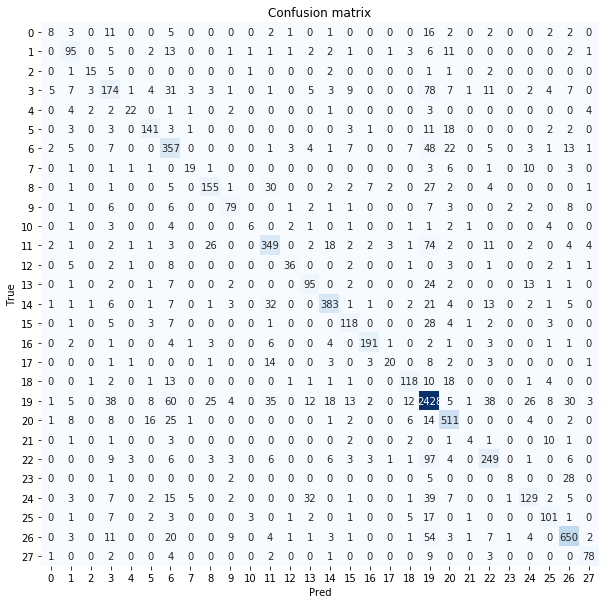

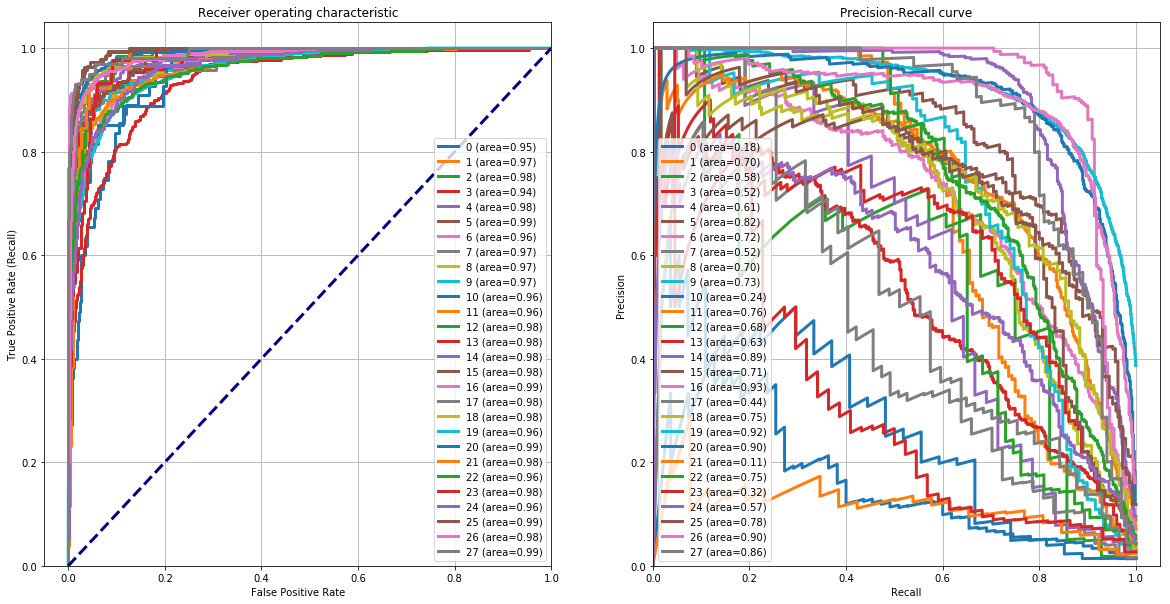

In [22]:
nn_Tfidf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(50), alpha=1, activation="relu", max_iter=1000, random_state=0)
nn_Tfidf.fit(X_Tfidf_train, y_Tfidf_train)

display_stats_model_trained(nn_Tfidf, X_Tfidf_train, y_Tfidf_train, X_Tfidf_test, y_Tfidf_test, True)

##### Conclusion sur le Neural Network Classifier

Le meilleur score pour ce modèle est obtenu avec les hyperparamètres suivants : `solver="lbfgs"`, `hidden_layer_sizes=(50)`, `alpha=1`, `activation="relu"` et `max_iter=5000`.

### Conlusion avec les résultats



Pour l'algorithme **RandomTree**, les scores obtenus sont un peu plus faibles, ce modèle ne sera donc pas retenu.

Le **KNN** propose lui aussi un manque de précision pour notre application.

Pour finir, le **Neural Network** est le modèle avec le meilleur score. Le précision pour le test atteint les **0.75** pour une liste d'hyperparamètres. Il s'agit du modèle le plus prometteur, car il est possible de faire encore évoluer ces paramètres.

Nous pouvons essayer d'améliorer la précision des réseaux de neuronnes en diminuant **l'Overfitting** avec la méthode du **drop out**. Nous pouvons essayer de mettre en place le drop out avec des `DNNClassfier` disponibles sous Tensorflow/Keras.